ThinkDSP
========
by Allen Downey (think-dsp.com)

This notebook contains examples and demos for a SciPy 2015 talk.

In [ ]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

--2021-09-30 07:48:51--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py [following]
--2021-09-30 07:48:51--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48687 (48K) [text/plain]
Saving to: ‘thinkdsp.py’

thinkdsp.py         100%[===================>]  47.55K  --.-KB/s    in 0.001s  

2021-09-30 07:48:51 (46.8 MB/s) - ‘thinkdsp.py’ saved [48687/48687]



In [ ]:
import thinkdsp
from thinkdsp import decorate

import numpy as np

A Signal represents a function that can be evaluated at an point in time.

In [ ]:
cos_sig = thinkdsp.CosSignal(freq=440)

A cosine signal at 440 Hz has a period of 2.3 ms.

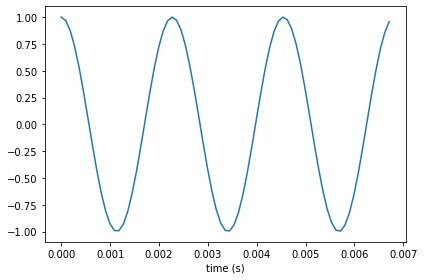

In [ ]:
cos_sig.plot()
decorate(xlabel='time (s)')

`make_wave` samples the signal at equally-space time steps.

In [ ]:
wave = cos_sig.make_wave(duration=0.5, framerate=11025)

`make_audio` creates a widget that plays the Wave.

In [ ]:
wave.apodize()
wave.make_audio()

`make_spectrum` returns a Spectrum object.

In [ ]:
spectrum = wave.make_spectrum()

A cosine wave contains only one frequency component (no harmonics).

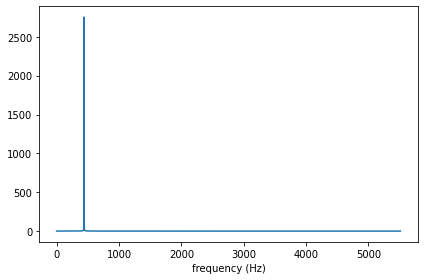

In [ ]:
spectrum.plot()
decorate(xlabel='frequency (Hz)')

A SawTooth signal has a more complex harmonic structure.

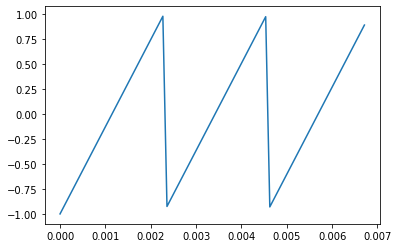

In [ ]:
saw_sig = thinkdsp.SawtoothSignal(freq=440)
saw_sig.plot()

Here's what it sounds like:

In [ ]:
saw_wave = saw_sig.make_wave(duration=0.5)
saw_wave.make_audio()

And here's what the spectrum looks like:

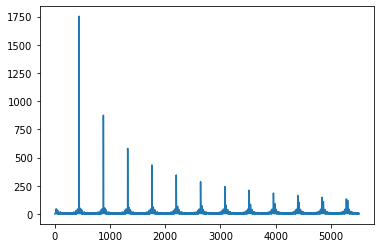

In [ ]:
saw_wave.make_spectrum().plot()

Here's a short violin performance from jcveliz on freesound.org:

In [ ]:
violin = thinkdsp.read_wave('X.wav')
violin.make_audio()

The spectrogram shows the spectrum over time:

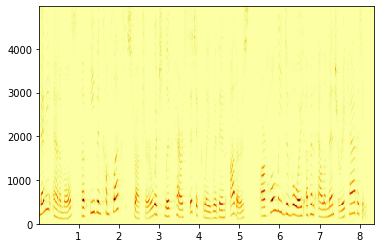

In [ ]:
spectrogram = violin.make_spectrogram(seg_length=1024)
spectrogram.plot(high=5000)

We can select a segment where the pitch is constant:

In [ ]:
start = 0 
duration = 26 
segment = violin.segment(start, duration)

And compute the spectrum of the segment:

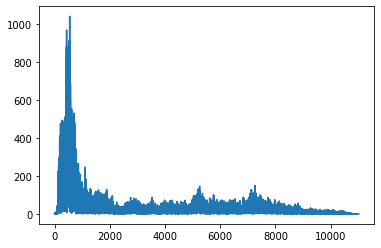

In [ ]:
spectrum = segment.make_spectrum()
spectrum.plot()

The dominant and fundamental peak is at 438.3 Hz, which is a slightly flat A4 (about 7 cents). 

In [ ]:
spectrum.peaks()[:5]

[(1039.8676463434688, 548.4333985071241),
 (967.397665428893, 436.72210039644386),
 (915.3174145007159, 552.4826353256349),
 (910.8826117305489, 524.6143583982371),
 (889.5207896176324, 552.7208257267238)]

As an aside, you can use the spectrogram to help extract the Parson's code and then identify the song.

Parson's code: DUUDDUURDR

Send it off to http://www.musipedia.org

A chirp is a signal whose frequency varies continuously over time (like a trombone).

In [ ]:
import math
PI2 = 2 * math.pi

class SawtoothChirp(thinkdsp.Chirp):
    """Represents a sawtooth signal with varying frequency."""

    def _evaluate(self, ts, freqs):
        """Helper function that evaluates the signal.

        ts: float array of times
        freqs: float array of frequencies during each interval
        """
        dts = np.diff(ts)
        dps = PI2 * freqs * dts
        phases = np.cumsum(dps)
        phases = np.insert(phases, 0, 0)
        cycles = phases / PI2
        frac, _ = np.modf(cycles)
        ys = thinkdsp.normalize(thinkdsp.unbias(frac), self.amp)
        return ys

Here's what it looks like:

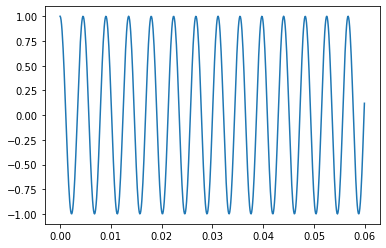

In [ ]:
signal = SawtoothChirp(start=220, end=880)
wave = signal.make_wave(duration=2, framerate=10000)
segment = wave.segment(duration=0.06)
segment.plot()

Here's the spectrogram.

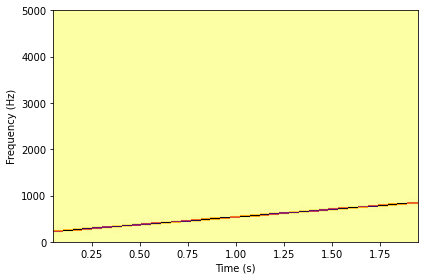

In [ ]:
spectrogram = wave.make_spectrogram(1024)
spectrogram.plot()
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

What do you think it sounds like?

In [ ]:
wave.apodize()
wave.make_audio()

Up next is one of the coolest examples in Think DSP.  It uses LTI system theory to characterize the acoustics of a recording space and simulate the effect this space would have on the sound of a violin performance.

I'll start with a recording of a gunshot:

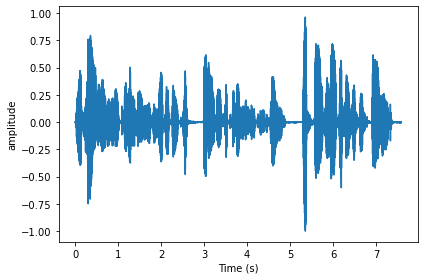

In [ ]:
response = thinkdsp.read_wave('Y.wav')

start = 0
response = response.segment(start=start)
response.shift(-start)

response.normalize()
response.plot()
decorate(xlabel='Time (s)', ylabel='amplitude')

If you play this recording, you can hear the initial shot and several seconds of echos.

In [ ]:
response.make_audio()

This wave records the "impulse response" of the room where the gun was fired.

Now let's load a recording of a violin performance:

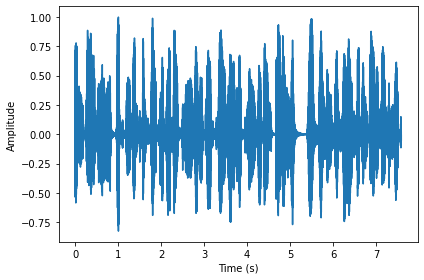

In [ ]:
wave = thinkdsp.read_wave('X.wav')
start = 0.11
wave = wave.segment(start=start)
wave.shift(-start)

wave.truncate(len(response))
wave.normalize()
wave.plot()
decorate(xlabel='Time (s)', ylabel='Amplitude')

And listen to it:

In [ ]:
wave.make_audio()

Now we can figure out what the violin would sound like if it was played in the room where the gun was fired.  All we have to do is convolve the two waves:

In [ ]:
output = wave.convolve(response)
output.normalize()

Here's what it looks like:

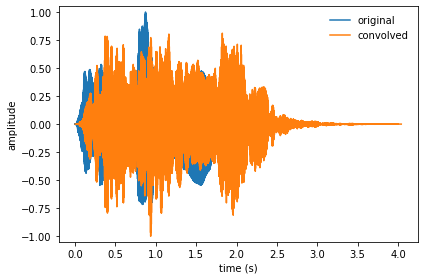

In [ ]:
wave.plot(label='original')
output.plot(label='convolved')
decorate(xlabel='Time (s)', ylabel='Amplitude')

And here's what it sounds like:

In [ ]:
output.make_audio()

If you think this example is black magic, you are not alone.   But there is a good reason why this works, and I do my best to explain it in Chapter 9.  So stay tuned.

I'd like to thanks jcveliz and kleeb for making these recordings available from freesound.org.